In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import string
import re
import spacy
import gensim
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../topic_data.csv')

In [3]:
df_copy = df.copy()

In [4]:
df_copy.describe()

,raw_text_length,year,month,cleaned_text_length
count,4568.000000,4568.0,4568.000000,4568.000000
mean,27.330560,2023.0,3.703590,24.769483
std,11.840659,0.0,0.456724,11.581002
min,1.000000,2023.0,3.000000,1.000000
25%,17.000000,2023.0,3.000000,15.000000
50%,27.000000,2023.0,4.000000,24.000000
75%,37.000000,2023.0,4.000000,34.000000
max,61.000000,2023.0,4.000000,57.000000


In [5]:
df_copy.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568 entries, 0 to 4567
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 4568 non-null   object
 1   date                 4568 non-null   object
 2   raw_text_length      4568 non-null   int64 
 3   year                 4568 non-null   int64 
 4   month                4568 non-null   int64 
 5   cleaned_text         4568 non-null   object
 6   cleaned_text_length  4568 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 3.2 MB


**Memory management**

In [6]:
# Memory management
def memory_magment(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != np.object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8) # int 8
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16) # int 16
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)  # in 32
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) # int 64 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else: 
                    df[col] = df[col].astype(np.float64)
    return df
df_memory = df_copy.copy()
df_memory = memory_magment(df_memory)    

In [7]:
df_memory.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568 entries, 0 to 4567
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 4568 non-null   object
 1   date                 4568 non-null   object
 2   raw_text_length      4568 non-null   int8  
 3   year                 4568 non-null   int16 
 4   month                4568 non-null   int8  
 5   cleaned_text         4568 non-null   object
 6   cleaned_text_length  4568 non-null   int8  
dtypes: int16(1), int8(3), object(3)
memory usage: 3.1 MB


Memory reduced from 3.2 --> 3.1 MB

**Preprocessing the data to obtain the tokens.**

- The cleaned_text version will be made use of for this process.

In [8]:
df_memory.sample(n=2,random_state=42)

,text,date,raw_text_length,year,month,cleaned_text,cleaned_text_length
1552,US SB 686 | Real-World Ministry of Truth Being...,2023-03-28 15:35:04+00:00,15,2023,3,us sb real world ministry of truth being estab...,14
23,Exclusive — Rep. Jeff Van Drew: Democrats Afra...,2023-04-03 10:56:07+00:00,20,2023,4,exclusive rep jeff van drew democrats afraid d...,17


In [9]:
featured_data = df_memory[['cleaned_text']]

In [10]:
featured_data

,cleaned_text
0,ah yes just love waking up to the sweet aroma...
1,when flies to georgia to take part in protest ...
2,exclusive rep jeff van drew democrats afraid o...
3,it april at pm stop your period pain instantly...
4,pmatcbidiamondjubilee corruption and dynastic...
...,...
4563,if the word cannot provoke you to preach the g...
4564,cept my own and that of the manager my name pr...
4565,graham potter chelsea exit set for huge impact...
4566,how to watch manchester united vs brentford us...


In [11]:
from spacy.lang.en.stop_words import STOP_WORDS

all_stopwords = STOP_WORDS
my_stop_words = set(all_stopwords) # My own stop words

In [12]:
nlp = spacy.load("en_core_web_sm")

def spacy_tokeniser(sent):
    sent = sent.strip().lower()
    doc = nlp(sent)
    mytokens = [token.lemma_ for token in doc if token.text not in my_stop_words]
    return mytokens

featured_data['tokens'] = featured_data['cleaned_text'].apply(spacy_tokeniser)

In [13]:
# Compute bigrams
from gensim.models import Phrases
from gensim.models.phrases import Phraser,ENGLISH_CONNECTOR_WORDS

In [14]:
docs = featured_data['tokens'].tolist()

In [15]:
# docs

In [16]:
docs[0][:8] # from document 1

['ah', 'yes', 'love', 'wake', 'sweet', 'aroma', 'political', 'chaos']

In [17]:
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram_phrases = Phrases(docs, min_count=20,connector_words=ENGLISH_CONNECTOR_WORDS)
trigram_phrases = Phrases(bigram_phrases[docs], min_count=30)

In [18]:
bigram = Phraser(bigram_phrases)
trigam = Phraser(trigram_phrases)

In [19]:
def make_bigram(texts):
    return([bigram[doc] for doc in texts])

def make_trigam(texts):
    return([trigam[bigram[doc]] for doc in texts])

In [20]:
bigrams_docs = make_bigram(docs)
trigrams_bigrams_docs = make_trigam(bigrams_docs)

In [21]:
print(trigrams_bigrams_docs[200][:])

['exclusive_rep_jeff_van', 'draw_democrats_afraid_donald', 'trump_corruption_win']


In [22]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
id2word = Dictionary(trigrams_bigrams_docs)
# or 
# dictionary = Dictionary(docs)


# Filter out words that occur less than 20 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below=20, no_above=0.5)

In [29]:
# id2word.most_common(20) # most common words
# [('ai', 1005),
#  ('healthcare', 719),
#  ('usa', 594),
#  ('amp', 528),
#  ('corruption', 525),
#  ('truth', 516),
#  ('disaster', 455),
#  ('virus', 413),
#  ('manager', 387),
#  ('politic', 343),
#  ('football', 317),
#  ('new', 261),
#  ('world', 211),
#  ('like', 200),
#  ('people', 191),
#  ('trump', 186),
#  ('time', 182),
#  ('datum_science', 180),
#  ('machine_learn', 170),
#  ('nigeriadecide', 165)]

In [24]:
# Bag-of-words representation of the documents.
# Term document frequency 
bow_corpus = [id2word.doc2bow(doc) for doc in trigrams_bigrams_docs]

In [25]:
# Create corpus
texts = trigrams_bigrams_docs

In [26]:
print(f'Number of unique tokens: { len(id2word)}')
print(f'Number of documents: {len(bow_corpus)}')

Number of unique tokens: 612
Number of documents: 4568


In [28]:
print(df_memory.loc[200,'text'])
print(featured_data.loc[200,"cleaned_text"])
print(featured_data.loc[200,"tokens"])

Exclusive — Rep. Jeff Van Drew: Democrats Afraid Donald Trump Will Take Out 'Corruption' if He Wins in 2024 https://t.co/A8CzILhxt0
exclusive rep jeff van drew democrats afraid donald trump will take out corruption if he wins in 
['exclusive', 'rep', 'jeff', 'van', 'draw', 'democrats', 'afraid', 'donald', 'trump', 'corruption', 'win']


In [30]:
# Verifying BOW is set up correctly
print(f" Cleaned Text: \n{featured_data.loc[200,'cleaned_text']}")
print(f"Bow representation: {bow_corpus[200]}")

document_200 = bow_corpus[200]
for i in range(len(document_200)):
    print(f"Word {document_200[i][0]}, {id2word[document_200[i][0]]}, appears {document_200[i][1]}")

 Cleaned Text: 
exclusive rep jeff van drew democrats afraid donald trump will take out corruption if he wins in 
Bow representation: [(10, 1), (36, 1), (40, 1)]
Word 10, exclusive_rep_jeff_van, appears 1
Word 36, draw_democrats_afraid_donald, appears 1
Word 40, trump_corruption_win, appears 1


### **Determining best number of topics**

In [31]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

In [32]:
def compute_coherence_scores(corpus, dictionary,k,a=None,b=None):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                            num_topics=k,
                                            id2word=dictionary,
                                            chunksize=2000,
                                            passes=50,
                                            iterations=400,
                                            random_state=42,
                                            workers=2,
                                            eval_every = None 
                                            # Don't evaluate model perplexity, takes too much time.
                                            )

    coherence_model_lda = CoherenceModel(model=lda_model,
                                        # texts=texts,
                                        corpus=corpus,
                                        dictionary=dictionary,
                                        coherence="u_mass",
                                        processes=-2)                            
                                                                    

    return coherence_model_lda.get_coherence()

In [33]:
model_results = {
    "topics": [],
    "coherence_score": [],
}

start = 2
stop = 10

In [34]:
# iterate through number of topics
for k in range(start,stop+1):
            score = compute_coherence_scores(corpus=bow_corpus,
                                        dictionary=id2word,
                                        k=k,
                                        )

            model_results["topics"].append(k) 
            model_results["coherence_score"].append(score) 

In [35]:
model_results_frame = pd.DataFrame(model_results)
model_results_frame.to_csv("model_versions/results/trigrams_results_umass.csv", index=False)

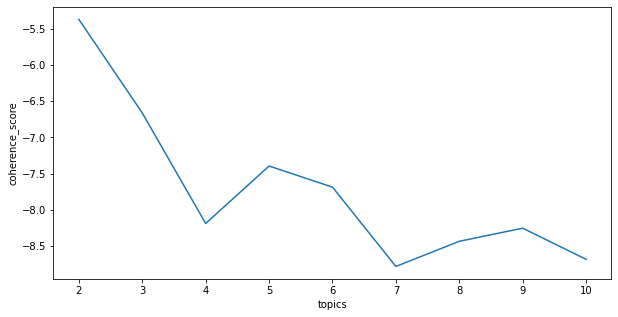

In [36]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=model_results_frame,x='topics',y="coherence_score")
plt.show()

In [37]:
coherence_scores = []
for topic, coherence_score in zip(*model_results.values()):
    print(f"Topic {topic} has a coherence_score of {coherence_score}")
    coherence_scores.append(coherence_score)

Topic 2 has a coherence_score of -5.373939294600994
Topic 3 has a coherence_score of -6.6631507600790805
Topic 4 has a coherence_score of -8.186600821316446
Topic 5 has a coherence_score of -7.395357456914877
Topic 6 has a coherence_score of -7.686222888861278
Topic 7 has a coherence_score of -8.778886253220454
Topic 8 has a coherence_score of -8.432205209702067
Topic 9 has a coherence_score of -8.251646566272278
Topic 10 has a coherence_score of -8.680619509159843


In [38]:
coherence_scores[np.argmin(coherence_scores,axis=0)]

-8.778886253220454

Overall best score is topic 7, but we will explore topics 10, 9, 8, 7 and 4 topics.

*Kindly note that pyLDAvis topics numbering starts from 1, so topic 1 is 0, etc*

In [39]:
optimal_model_ten = gensim.models.LdaMulticore(corpus=bow_corpus,
                                            num_topics=10,
                                            id2word=id2word,
                                            chunksize=2000,
                                            passes=50,
                                            iterations=400,
                                            random_state=42,
                                            workers=2,)

In [40]:
optimal_model_ten.print_topics(num_words=20)

[(0,
  '0.180*"football" + 0.048*"day" + 0.038*"play" + 0.022*"league" + 0.021*"club" + 0.018*"sport" + 0.018*"player" + 0.017*"amp" + 0.016*"go" + 0.015*"th" + 0.015*"know" + 0.014*"high" + 0.014*"game" + 0.013*"match" + 0.013*"world" + 0.013*"great" + 0.013*"want" + 0.012*"book" + 0.012*"guy" + 0.011*"april"'),
 (1,
  '0.072*"manager" + 0.040*"football" + 0.038*"new" + 0.035*"game" + 0.034*"good" + 0.034*"project" + 0.027*"team" + 0.025*"bad" + 0.024*"job" + 0.023*"look" + 0.023*"work" + 0.022*"come" + 0.020*"fan" + 0.019*"like" + 0.018*"amp" + 0.014*"make" + 0.014*"way" + 0.013*"know" + 0.012*"time" + 0.012*"say"'),
 (2,
  '0.127*"ai" + 0.094*"healthcare" + 0.019*"amp" + 0.018*"technology" + 0.017*"artificialintelligence" + 0.015*"industry" + 0.015*"future" + 0.013*"patient" + 0.013*"datum" + 0.012*"health" + 0.012*"read" + 0.012*"healthtech" + 0.011*"chatgpt" + 0.011*"care" + 0.011*"innovation" + 0.011*"change" + 0.011*"machinelearne" + 0.010*"tech" + 0.009*"medical" + 0.009*"trans

### **Visualising the topics**

In [41]:
# visualise the topics
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
vis_data_ten = gensimvis.prepare(optimal_model_ten,bow_corpus,id2word, sort_topics=False)
pyLDAvis.save_html(vis_data_ten, 'topic_visuals_trigrams/topics_of_10.html')
pyLDAvis.display(vis_data_ten)

**Observations**

Based off the plot the following could be observed:
- Topics 1 and 7 are overlapping but from inspection, I could see manchester and united in topic 7 whereas topic 1 is about sports, maybe a lower number of topics is needed ?
- Topics 2, 4, 5 and 10 are overalapping. Topics 2,5 & 10 could be talking about sports, while topic 4 is somewhat a mixture of sports and politics. I believe a lower number of topics should be used.
- Topic 8 is clearly about politics.
- Topics 9 and 3 is about AI and healthcare.
- Topic 6 isn't quite clear.

In [42]:
optimal_model_nine = gensim.models.LdaMulticore(corpus=bow_corpus,
                                            num_topics=9,
                                            id2word=id2word,
                                            chunksize=2000,
                                            passes=50,
                                            iterations=400,
                                            random_state=42,
                                            workers=2,)

In [43]:
optimal_model_nine.print_topics(num_words=20)

[(0,
  '0.125*"football" + 0.034*"day" + 0.027*"datum_science" + 0.024*"machine_learn" + 0.020*"python" + 0.019*"club" + 0.016*"amp" + 0.014*"machine_learning" + 0.014*"game" + 0.014*"learn" + 0.014*"include" + 0.013*"sport" + 0.013*"way" + 0.012*"book" + 0.012*"april" + 0.012*"guy" + 0.011*"data_science" + 0.011*"well" + 0.011*"cup" + 0.011*"follow"'),
 (1,
  '0.070*"manager" + 0.042*"football" + 0.030*"new" + 0.021*"disaster" + 0.020*"share" + 0.020*"amp" + 0.018*"buy" + 0.017*"game" + 0.017*"business" + 0.017*"high" + 0.014*"find" + 0.013*"like" + 0.013*"happy" + 0.012*"work" + 0.011*"happen" + 0.011*"finally" + 0.011*"development" + 0.010*"quality" + 0.010*"app" + 0.010*"national"'),
 (2,
  '0.112*"ai" + 0.083*"healthcare" + 0.016*"amp" + 0.016*"technology" + 0.015*"artificialintelligence" + 0.014*"datum" + 0.013*"new" + 0.013*"industry" + 0.012*"future" + 0.012*"patient" + 0.011*"health" + 0.011*"sale" + 0.010*"healthtech" + 0.010*"care" + 0.010*"innovation" + 0.009*"chatgpt" + 0.

### **Visualising the topics**

In [44]:
# visualise the topics
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
# pyLDAvis.enable_notebook(local=True)
vis_data_nine = gensimvis.prepare(optimal_model_nine,bow_corpus,id2word, sort_topics=False)
pyLDAvis.save_html(vis_data_nine, 'topic_visuals_trigrams/topics_of_9.html')
pyLDAvis.display(vis_data_nine)

**Observations**

Based off the plot the following could be observed:
- Topics 2,4,5 & 7(although far) seems to be related, the word *manager* appears in them in the top two frequent tokens. Topic 1 seems to be unclear mixture of AI and sports.
- Topics 3 and 8 definitely are different as topic 8 is about politics while 3 is about ai and healthcare. I believe topic 1 would be also closer to Topic 3.
- Topics 9 and 6 are not so clear.

In [59]:
optimal_model_eight = gensim.models.LdaMulticore(corpus=bow_corpus,
                                            num_topics=8,
                                            id2word=id2word,
                                            chunksize=2000,
                                            passes=50,
                                            iterations=400,
                                            random_state=42,
                                            workers=2,)

In [60]:
optimal_model_eight.print_topics(num_words=20)

[(0,
  '0.139*"football" + 0.037*"day" + 0.020*"bad" + 0.018*"datum_science" + 0.018*"high" + 0.018*"club" + 0.017*"amp" + 0.016*"python" + 0.016*"machine_learn" + 0.015*"game" + 0.015*"want" + 0.014*"like" + 0.014*"play" + 0.012*"sport" + 0.012*"player" + 0.011*"watch" + 0.011*"know" + 0.011*"buy" + 0.011*"book" + 0.011*"hope"'),
 (1,
  '0.071*"disaster" + 0.042*"manager" + 0.032*"amp" + 0.021*"job" + 0.020*"come" + 0.019*"way" + 0.019*"new" + 0.018*"corruption" + 0.015*"like" + 0.014*"people" + 0.013*"hire" + 0.012*"help" + 0.012*"find" + 0.011*"official" + 0.011*"good" + 0.011*"feel" + 0.011*"opportunity" + 0.010*"work" + 0.010*"public" + 0.010*"safe"'),
 (2,
  '0.096*"ai" + 0.071*"healthcare" + 0.024*"manager" + 0.020*"new" + 0.019*"post" + 0.014*"technology" + 0.013*"site" + 0.013*"artificialintelligence" + 0.012*"industry" + 0.012*"web" + 0.011*"publish" + 0.011*"datum" + 0.011*"quality" + 0.011*"future" + 0.010*"cross" + 0.010*"patient" + 0.010*"amp" + 0.009*"chatgpt" + 0.009*"h

### **Visualising the topics**

In [61]:
# visualise the topics
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
vis_data_eight = gensimv and and and and adnjjis.prepare(optimal_model_eight,bow_corpus,id2word, sort_topics=False)
pyLDAvis.save_html(vis_data_eight, 'topic_visuals_trigrams/topics_of_8.html')
pyLDAvis.display(vis_data_eight)

**Observations**

Based off the plot the following could be observed:
- Topic 5 is about sports.
- Topic 7 isn't quite clear
- Topic 4 could be about sports and politics.
- Topic 1 is about possibly AI and sports.
- Topic 3 is about AI and healthcare.
- Topic 2 could be about global affairs; politics.
- Topic 8 is about politics.
- Topic 6 seems to be about sports or maybe politics.

In [62]:
optimal_model_seven = gensim.models.LdaMulticore(corpus=bow_corpus,
                                            num_topics=7,
                                            id2word=id2word,
                                            chunksize=2000,
                                            passes=50,
                                            iterations=400,
                                            random_state=42,
                                            workers=2,)

In [63]:
optimal_model_seven.print_topics(num_words=20)

[(0,
  '0.140*"football" + 0.021*"day" + 0.020*"play" + 0.019*"time" + 0.018*"game" + 0.016*"team" + 0.015*"club" + 0.015*"watch" + 0.015*"match" + 0.015*"amp" + 0.014*"datum_science" + 0.014*"machine_learn" + 0.013*"python" + 0.013*"ve" + 0.012*"share" + 0.011*"league" + 0.011*"good" + 0.011*"like" + 0.011*"high" + 0.010*"data_science"'),
 (1,
  '0.050*"usa" + 0.047*"corruption" + 0.046*"truth" + 0.040*"disaster" + 0.032*"amp" + 0.031*"politic" + 0.016*"trump" + 0.014*"people" + 0.010*"government" + 0.010*"like" + 0.009*"country" + 0.009*"world" + 0.009*"news" + 0.008*"life" + 0.008*"president" + 0.008*"china" + 0.008*"lie" + 0.008*"biden" + 0.008*"know" + 0.007*"go"'),
 (2,
  '0.095*"ai" + 0.071*"healthcare" + 0.024*"new" + 0.018*"manager" + 0.017*"amp" + 0.015*"post" + 0.014*"technology" + 0.013*"site" + 0.013*"artificialintelligence" + 0.013*"datum" + 0.012*"industry" + 0.011*"web" + 0.011*"future" + 0.010*"publish" + 0.010*"quality" + 0.010*"cross" + 0.010*"patient" + 0.009*"chatg

### **Visualising the topics**

In [64]:
# visualise the topics
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
vis_data_seven = gensimvis.prepare(optimal_model_seven,bow_corpus,id2word, sort_topics=False)
pyLDAvis.save_html(vis_data_seven, 'topic_visuals_trigrams/topics_of_7.html')
pyLDAvis.display(vis_data_seven)

**Observations**

Based off the plot the following could be observed:
- Topic 1 is about sports.
- Topic 2 is about politics.
- Topic 3 is about healthcare and AI.
- Topic 4 could be about politics and sports.
- Topic 5 is about sports.
- Topic 6 is seems to be about sports and maybe politics?
- Topic 7 could be about politics ?

In [65]:
optimal_model_four = gensim.models.LdaMulticore(corpus=bow_corpus,
                                            num_topics=4,
                                            id2word=id2word,
                                            chunksize=2000,
                                            passes=50,
                                            iterations=400,
                                            random_state=42,
                                            workers=2,)

In [66]:
optimal_model_four.print_topics(num_words=50)

[(0,
  '0.097*"football" + 0.030*"game" + 0.023*"messi" + 0.022*"player" + 0.018*"play" + 0.017*"team" + 0.015*"win" + 0.015*"playoff" + 0.014*"day" + 0.013*"time" + 0.013*"good" + 0.011*"fire" + 0.011*"club" + 0.011*"god" + 0.011*"eat" + 0.011*"word" + 0.011*"college_football" + 0.011*"fan" + 0.011*"ronaldo" + 0.010*"season" + 0.010*"april_kyambogo" + 0.010*"pitch_pm" + 0.010*"psg" + 0.010*"league" + 0.010*"sport" + 0.010*"catchthefire" + 0.010*"new" + 0.010*"goal" + 0.009*"match" + 0.009*"kyuedition" + 0.009*"like" + 0.008*"ve" + 0.008*"world" + 0.007*"watch" + 0.007*"crypto" + 0.007*"man" + 0.007*"manchester" + 0.007*"home" + 0.007*"high" + 0.007*"work" + 0.007*"cup" + 0.007*"announce" + 0.007*"united" + 0.007*"want" + 0.007*"check" + 0.007*"child" + 0.006*"epl" + 0.006*"score" + 0.006*"woman" + 0.006*"feel"'),
 (1,
  '0.037*"usa" + 0.033*"corruption" + 0.032*"truth" + 0.028*"disaster" + 0.026*"virus" + 0.024*"amp" + 0.022*"politic" + 0.012*"people" + 0.012*"trump" + 0.011*"don" + 0

### **Visualising the topics**

In [67]:
# visualise the topics
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
vis_data_four = gensimvis.prepare(optimal_model_four,bow_corpus,id2word, sort_topics=False)
pyLDAvis.save_html(vis_data_four, 'topic_visuals_trigrams/topics_of_4.html')
pyLDAvis.display(vis_data_four)

**Observations**

Based off the plot the following could be observed:
- Topic 1 about sports.
- Topic 2 is about politics.
- Topic 3 is about AI and healthcare.
- Topic 4 seems to be about sports and politics? Should it be a general topic?

Best to move on with four topics

In [68]:
# Savming the model: Topics of 4
# optimal_model_four.save("model_versions/saved_models/trigrams/topics_of_4_.model")

In [69]:
from gensim import models
# Loading the model
my_model = gensim.models.LdaMulticore.load("model_versions/saved_models/trigrams/topics_of_4_.model")
my_model.print_topics(num_words=20)

[(0,
  '0.097*"football" + 0.030*"game" + 0.023*"messi" + 0.022*"player" + 0.018*"play" + 0.017*"team" + 0.015*"win" + 0.015*"playoff" + 0.014*"day" + 0.013*"time" + 0.013*"good" + 0.011*"fire" + 0.011*"club" + 0.011*"god" + 0.011*"eat" + 0.011*"word" + 0.011*"college_football" + 0.011*"fan" + 0.011*"ronaldo" + 0.010*"season"'),
 (1,
  '0.037*"usa" + 0.033*"corruption" + 0.032*"truth" + 0.028*"disaster" + 0.026*"virus" + 0.024*"amp" + 0.022*"politic" + 0.012*"people" + 0.012*"trump" + 0.011*"don" + 0.010*"say" + 0.010*"like" + 0.009*"get" + 0.009*"feel" + 0.009*"good" + 0.009*"world" + 0.008*"year" + 0.007*"government" + 0.007*"great" + 0.007*"know"'),
 (2,
  '0.082*"ai" + 0.059*"healthcare" + 0.017*"new" + 0.016*"amp" + 0.015*"post" + 0.015*"datum_science" + 0.014*"machine_learn" + 0.013*"datum" + 0.012*"technology" + 0.012*"site" + 0.011*"web" + 0.011*"artificialintelligence" + 0.011*"learn" + 0.010*"future" + 0.010*"industry" + 0.010*"python" + 0.010*"machine_learning" + 0.009*"publ

### **Appending the topics to the documents**

In [70]:
# lda_corpus = optimal_model_four[bow_corpus]
lda_corpus = my_model[bow_corpus]

In [71]:
topics_list = list(lda_corpus)

In [73]:
# topics_to_documents = [[item[0] for item in inner ] for inner in topics_list]
topics_to_documents = [[item[0] for item in inner if item[1] > 0.1] for inner in topics_list]

In [74]:
count = 0 
for i in lda_corpus:
    print(f"Document {count}: Topics: {i}")
    count +=1

Document 0: Topics: [(0, 0.0361838), (1, 0.8911391), (2, 0.03579144), (3, 0.03688563)]
Document 1: Topics: [(0, 0.05000489), (1, 0.8464993), (2, 0.050343793), (3, 0.053152014)]
Document 2: Topics: [(0, 0.08333737), (1, 0.08333714), (2, 0.08333769), (3, 0.74998784)]
Document 3: Topics: [(0, 0.9062406), (1, 0.031252816), (2, 0.031253222), (3, 0.03125336)]
Document 4: Topics: [(0, 0.035719864), (1, 0.89267766), (2, 0.035882447), (3, 0.035720006)]
Document 5: Topics: [(0, 0.3315141), (1, 0.031918082), (2, 0.029600615), (3, 0.60696715)]
Document 6: Topics: [(0, 0.029043937), (1, 0.9145722), (2, 0.02825821), (3, 0.028125731)]
Document 7: Topics: [(0, 0.031253587), (1, 0.5310864), (2, 0.031253863), (3, 0.40640616)]
Document 8: Topics: [(0, 0.035719864), (1, 0.8926773), (2, 0.035882812), (3, 0.035720006)]
Document 9: Topics: [(0, 0.05000459), (1, 0.84869033), (2, 0.050004918), (3, 0.051300164)]
Document 10: Topics: [(0, 0.20840612), (1, 0.5417138), (2, 0.04167046), (3, 0.20820965)]
Document 11

In [75]:
clustering  = df_memory[["text", "cleaned_text"]]

In [76]:
clustering["topics"] = topics_to_documents

In [77]:
clustering.head()

,text,cleaned_text,topics
0,"""Ah, yes. I just love waking up to the sweet a...",ah yes just love waking up to the sweet aroma...,[1]
1,When @ViolavonCramon\nflies to Georgia 🇬🇪 to t...,when flies to georgia to take part in protest ...,[1]
2,Exclusive — Rep. Jeff Van Drew: Democrats Afra...,exclusive rep jeff van drew democrats afraid o...,[3]
3,"It’s April 03, 2023 at 12:29PM\nStop Your Peri...",it april at pm stop your period pain instantly...,[0]
4,#PMAtCBIDiamondJubilee\nCorruption and dynasti...,pmatcbidiamondjubilee corruption and dynastic...,[1]


In [78]:
clustering.tail()

,text,cleaned_text,topics
4563,If the Word cannot provoke you to preach the g...,if the word cannot provoke you to preach the g...,[0]
4564,"cept\nmy own and that of the manager.\n\n""'My ...",cept my own and that of the manager my name pr...,[3]
4565,Graham Potter's Chelsea exit set for huge impa...,graham potter chelsea exit set for huge impact...,"[1, 3]"
4566,How to watch Manchester United vs Brentford - ...,how to watch manchester united vs brentford us...,[0]
4567,Erik ten Hag has contradicted himself over Wou...,erik ten hag has contradicted himself over wou...,[0]


In [79]:
print(f"Raw Text: {clustering.loc[1383,'text']}\n")
print(f"Cleaned Text: {clustering.loc[1383,'cleaned_text']}\n")
print(f"Topics: {clustering.loc[1383,'topics']}")

Raw Text: Exposing the truth. A great man against the Empire of Lies. Lavrov, a diplomat will mark history. 
Hopefully Russia will stop the decades-long terror of the USA &amp; the NATO pact. Go ahead, Russians, justice is with you. The time of reckoning has come. 

https://t.co/ULYdzexOYr

Cleaned Text: exposing the truth great man against the empire of lies lavrov diplomat will mark history hopefully russia will stop the decades long terror of the usa amp the nato pact go ahead russians justice is with you the time of reckoning has come 

Topics: [1, 3]


In [80]:
print(f"Raw Text: {clustering.loc[258,'text']}\n")
print(f"Cleaned Text: {clustering.loc[258,'cleaned_text']}\n")
print(f"Topics: {clustering.loc[258,'topics']}")

Raw Text: I love my political Daddy! Daddy of Modern Politics. Daddy of Politics without bitterness. Daddy of Issue Based Politics. Daddy of Politics of Competence. Daddy of Politics without corruption. We Love you Daddy, Yes Daddy!

Cleaned Text: i love my political daddy daddy of modern politics daddy of politics without bitterness daddy of issue based politics daddy of politics of competence daddy of politics without corruption we love you daddy yes daddy 

Topics: [1]


In [81]:
print(f"Raw Text: {clustering.loc[1882,'text']}\n")
print(f"Cleaned Text: {clustering.loc[1882,'cleaned_text']}\n")
print(f"Topics: {clustering.loc[1882,'topics']}")

Raw Text: Tweet: 📣 New AI tool alert! 🎉 Check out Buoy Health - an innovative digital health platform that helps users take control of their health with simple online tools &amp; personalized advice. #AiTopTools #DigitalHealth #ProactiveHealth #AI #Healthcare https://t.co/vLMrDiXXzF

Cleaned Text: tweet new ai tool alert check out buoy health an innovative digital health platform that helps users take control of their health with simple online tools amp personalized advice aitoptools digitalhealth proactivehealth ai healthcare 

Topics: [2]


In [82]:
clustering.to_csv("saved_trigrams_clusters_document/topics4_clustering1.csv")

Using trigrams seems to perform well too to an extent. It does reduce the number of topics with the use of trigrams, but I would recommend the use of bigrams and improve on its overall preprocessing stage and see what can be improved before stepping into the use of trigrams. 

*Kindly note:*

Mapping the topics to the graph;
- Topics 0 is 1 on the graph.
- Topics 1 is 2 on the graph.
- Topics 2 is 3 on the graph.
- Topics 3 is 4 on the graph.

Please remember the following observations from the graph for topic 4 but using the index numbering as specified here;
- Topic 0 is about sports.
- Topic 1 is about politics.
- Topic 2 is about AI and healthcare.
- Topic 3 seems to be about sports and politics? Should it be a general topic?

### **What's next?**

Usingthe following approaches:
- BERTopic